### Table of Contents
* [Support Functions & Loading The Models/ Data](#Functions)
* [Loading The Data](#LoadingData)
* [Visuals](#Visuals)
    * [All Reviews](#VisualsAll)
        * [Observations](#VisualsAllobservations)
    * [Positive Reviews](#VisualsPositive)
        * [Observations](#VisualsPositiveobservations)
    * [Negative Reviews](#VisualsNegative)
        * [Observations](#VisualsNegativeobservations)
* [Conclusions](#Conclusions)    

# Librarys

In [27]:
import numpy as np
import pandas as pd
import re, warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import gensim


# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim as gensimvis
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
import seaborn as sns
from collections import Counter

import pickle


from wordcloud import WordCloud
import matplotlib.colors as mcolors


pd.set_option("max_rows", None)
pd.set_option('display.width', None)
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', 200)

# Functions <a class="anchor" id="Functions"></a>

In [28]:
def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


def getTopReviewsForEachTopic(df_topic_sents_keywords):

    # Group top 5 sentences under each topic
    sent_topics_sorted = pd.DataFrame()
    df_append = pd.DataFrame()

    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
#         print(f'i = {i}')
#         print(grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5))


        df_topic_epitome_reviews = pd.concat([grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                                axis=0, ignore_index=True)

    #     testAppend =  grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)

        df_append = df_append.append(df_topic_epitome_reviews, ignore_index=True)

        #test = df_topic_sents_keywords1.groupby(['Dominant_Topic'], as_index=False)[0].count()

    #     print(type(df_topic_epitome_reviews))
    #     sent_topics_sorted

    # Reset Index    
    df_append.reset_index(drop=True, inplace=True)

    # Format
    df_append.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    return df_append


def createwordcloud(ldamodel, numberofTopics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = ldamodel.show_topics(formatted=False)


    if numberofTopics <=4:
        fig, axes = plt.subplots(1, 4, figsize=(15,10), sharex=True, sharey=True)
#     elif numberofTopics<=6:
#         fig, axes = plt.subplots(2, 3, figsize=(15,20), sharex=True, sharey=True)
#     elif numberofTopics<=9:
#         fig, axes = plt.subplots(3, 3, figsize=(15,30), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i < numberofTopics:
            #print("here")
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.axis('off')
            plt.margins(x=0, y=0)
        else:
            k = 1
   
    plt.tight_layout()
    plt.show()
    
def showTopwordsPertopicInGraph (ldamodel):
    from collections import Counter
    topics = ldamodel.show_topics(formatted=False)
    data_flat = [w for w_list in doc_clean_tokenized_Lem for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
    
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 2500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                label.set_fontname('Arial')
                label.set_fontsize(15)

        ax_twin.set_yticklabels([0, .02,.04,.06,.08], fontsize=15)

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()    
    return df

def gettopicwordsIntoDataframe(optimal_model):
    df_all = pd.DataFrame()
    for topic_idx, topic in enumerate(optimal_model.show_topics(formatted=False)):
        df = pd.DataFrame(topic[1], columns =['word', 'Percent'])
        df['Topic'] = topic_idx
        df_all = df_all.append(df)

    df_all['Percent'] = df_all['Percent'].astype(float).round(2)
    return df_all

def createheatmapofTopwords(df_all):

    fig, ax = plt.subplots(figsize=(17,100))
    sns.heatmap(pd.crosstab([df_all.Topic], [df_all.word]),
                cmap="YlGnBu", annot=True, cbar=False, xticklabels=True, yticklabels=True,
                vmax=1.5, vmin=0, square=True, 
                annot_kws={"fontsize":20}
               )
#     sns.set(font_scale=3)
    plt.show();
    

# Loading The Data <a class="anchor" id="LoadingData"></a>

In [29]:
file = open("./data/df_ModelInfo.pickle", "rb")
df_ModelInfo = pickle.load(file)
file.close

file = open("./data/df_ModelInfo_P.pickle", "rb")
df_ModelInfo_P = pickle.load(file)
file.close

file = open("./data/df_ModelInfo_N.pickle", "rb")
df_ModelInfo_N = pickle.load(file)
file.close


with open('./data/df_reviews.pickle', 'rb') as f:
    df_reviews = pickle.load(f)
      
with open('./data/df_reviews_P.pickle', 'rb') as f:
    df_reviews_P = pickle.load(f)

with open('./data/df_reviews_N.pickle', 'rb') as f:
    df_reviews_N = pickle.load(f)


# with open('doc_term_matrix.pickle', 'rb') as f:
#     doc_term_matrix = pickle.load(f)

with open('./data/doc_term_matrix_tfidf.pickle', 'rb') as f:
    doc_term_matrix = pickle.load(f)

with open('./data/doc_term_matrix_tfidf_P.pickle', 'rb') as f:
    doc_term_matrix_P = pickle.load(f)

with open('./data/doc_term_matrix_tfidf_N.pickle', 'rb') as f:
    doc_term_matrix_N = pickle.load(f)

    
data = df_reviews.Text.to_list()
data_P = df_reviews_P.Text.to_list()
data_N = df_reviews_N.Text.to_list()
# MalletFunctModel = optimal_modelHDP 

doc_clean_tokenized_Lem = [review.split() for review in df_reviews["TextClean4"]]
doc_clean_tokenized_Lem_P = [review.split() for review in df_reviews_P["TextClean4"]]
doc_clean_tokenized_Lem_N = [review.split() for review in df_reviews_N["TextClean4"]]


doc_tokenized = [review.split() for review in df_reviews["Text"]]

corpus_dictionary = Dictionary(doc_clean_tokenized_Lem)
corpus_dictionary_P = Dictionary(doc_clean_tokenized_Lem_P)
corpus_dictionary_N = Dictionary(doc_clean_tokenized_Lem_N)

In [30]:
df_ModelInfo

,ModelName,Model,NumberOfTopics,Coherence
0,ldatfidf,"LdaModel(num_terms=366, num_topics=4, decay=0.02, chunksize=50)",4,0.459288
1,ldatfidf,"LdaModel(num_terms=366, num_topics=5, decay=0.02, chunksize=50)",5,0.524011
2,ldatfidf,"LdaModel(num_terms=366, num_topics=6, decay=0.02, chunksize=50)",6,0.476567
3,ldatfidf,"LdaModel(num_terms=366, num_topics=7, decay=0.02, chunksize=50)",7,0.457514


In [31]:
df_ModelInfo_P

,ModelName,Model,NumberOfTopics,Coherence
0,ldatfidf,"LdaModel(num_terms=366, num_topics=4, decay=0.02, chunksize=50)",4,0.497222
1,ldatfidf,"LdaModel(num_terms=366, num_topics=5, decay=0.02, chunksize=50)",5,0.497486
2,ldatfidf,"LdaModel(num_terms=366, num_topics=6, decay=0.02, chunksize=50)",6,0.557967
3,ldatfidf,"LdaModel(num_terms=366, num_topics=7, decay=0.02, chunksize=50)",7,0.546413


In [32]:
df_ModelInfo_N

,ModelName,Model,NumberOfTopics,Coherence
0,ldatfidf,"LdaModel(num_terms=292, num_topics=2, decay=0.02, chunksize=50)",2,0.603598
1,ldatfidf,"LdaModel(num_terms=292, num_topics=3, decay=0.02, chunksize=50)",3,0.689918


In [33]:
# Select the model and print the topics
# HDPnumberOfTopics = 5
numberOfTopics = 4
optimal_model = df_ModelInfo[(df_ModelInfo["ModelName"] == "ldatfidf") & (df_ModelInfo["NumberOfTopics"]==numberOfTopics)]["Model"].values[0]

numberOfTopics_P = 4
optimal_model_P = df_ModelInfo_P[(df_ModelInfo_P["ModelName"] == "ldatfidf") & (df_ModelInfo_P["NumberOfTopics"]==numberOfTopics_P)]["Model"].values[0]

numberOfTopics_N = 2
optimal_model_N = df_ModelInfo_N[(df_ModelInfo_N["ModelName"] == "ldatfidf") & (df_ModelInfo_N["NumberOfTopics"]==numberOfTopics_N)]["Model"].values[0]


In [34]:
len(df_reviews_N)

134

# Visualizing Results <a class="anchor" id="Visuals"></a>

In [35]:
print(f' Number of Positive Reviews: {len(df_reviews_P)}')
print(f' Number of Negative Reviews: {len(df_reviews_N)}')
print(f' Percent Negative Reviews = : {round(100*(len(df_reviews_N)/len(df_reviews_P)),0)}%')

 Number of Positive Reviews: 1511
 Number of Negative Reviews: 134
 Percent Negative Reviews = : 9.0%


## All Reviews <a class="anchor" id="VisualsAll"></a>

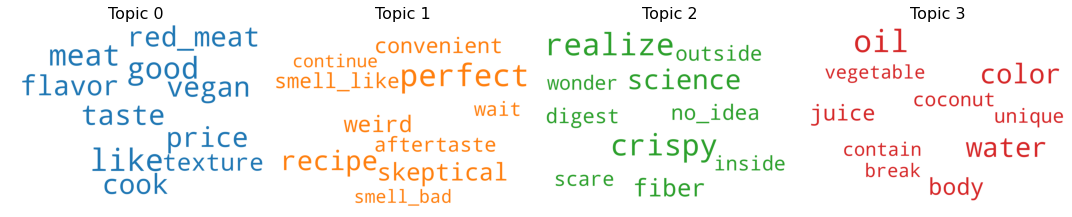

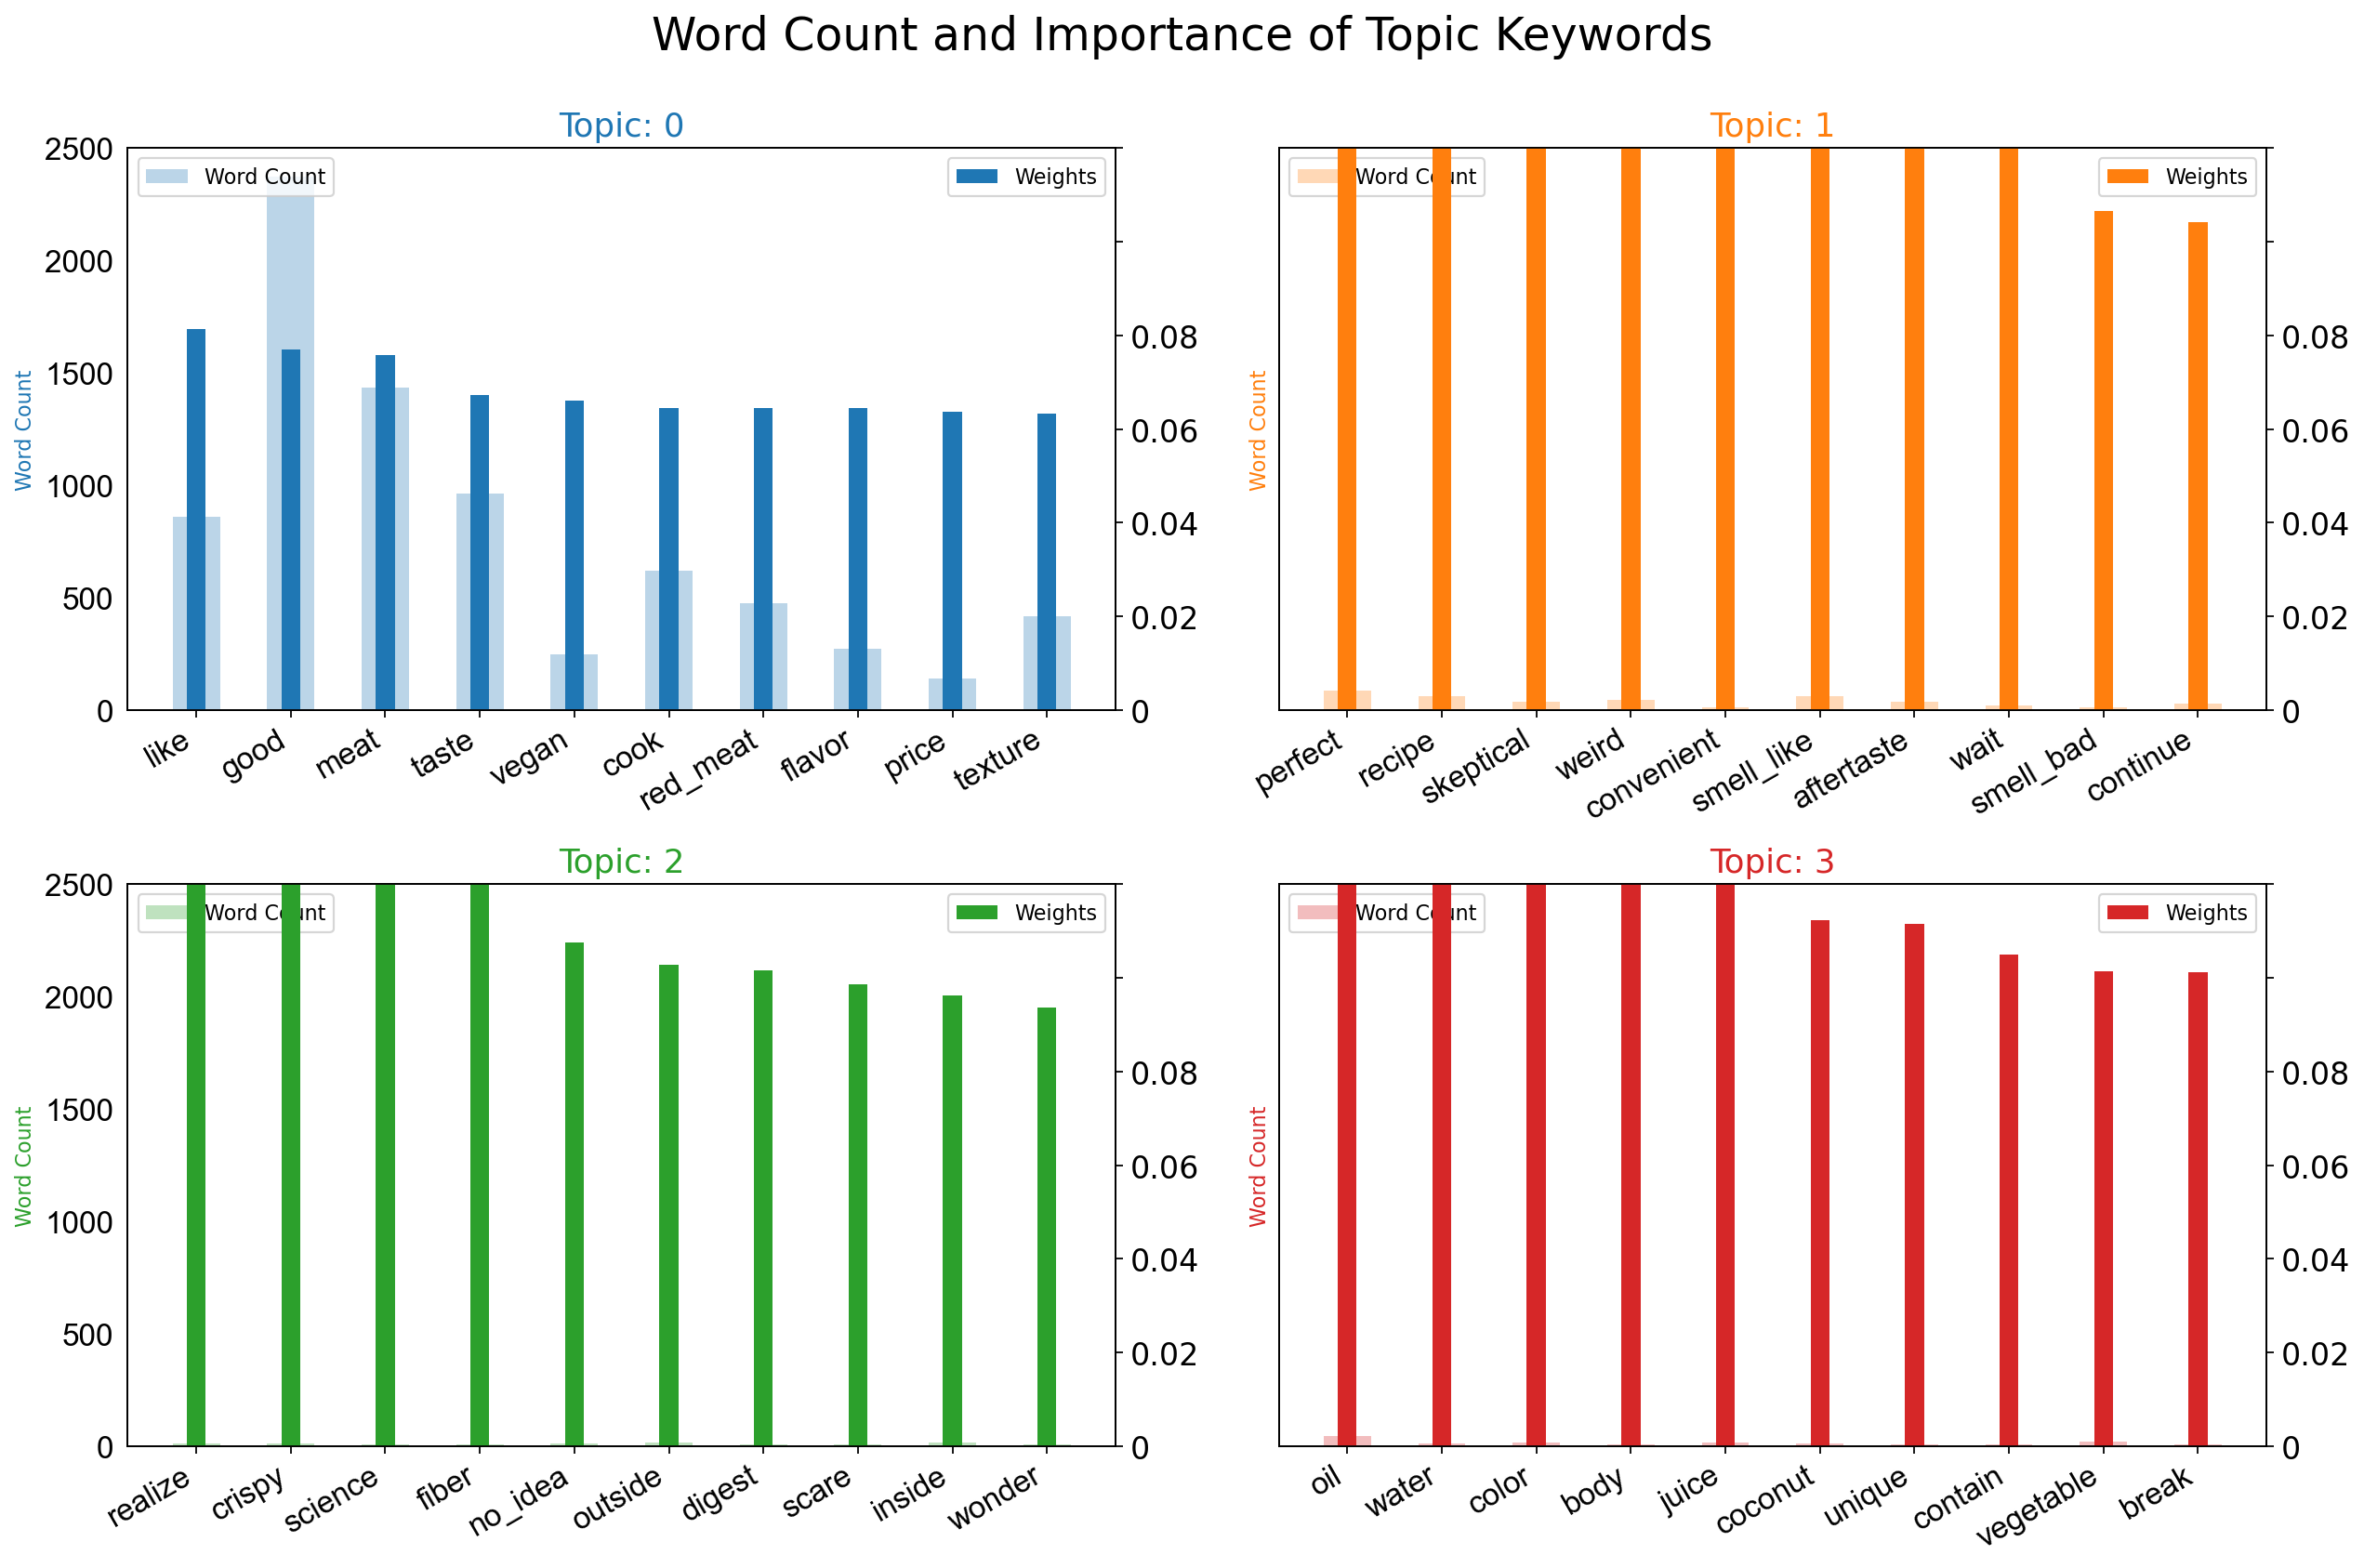

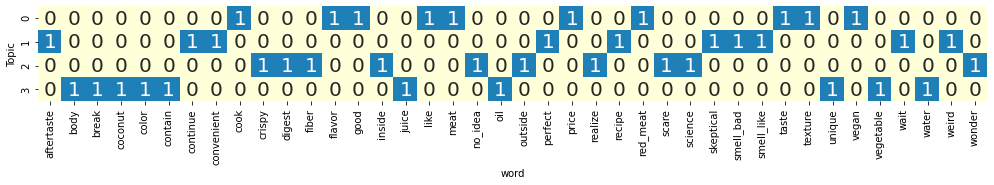

In [36]:
df_topic_sents_keywords = format_topics_sentences(optimal_model, doc_term_matrix, data)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.to_excel("df_TopReviewPerTopic.xlsx")

df_TopReviewPerTopic = getTopReviewsForEachTopic(df_topic_sents_keywords)

df_reviewsInitialText = df_reviews[['Text','TextClean', 'TextClean4']]
df_TopReviewPerTopic.merge(df_reviewsInitialText, how='left', on='Text')
df_TopReviewPerTopic.head()

df_TopReviewPerTopic.to_excel("df_TopReviewPerTopic.xlsx")

createwordcloud(optimal_model, numberOfTopics)
df_wordImp = showTopwordsPertopicInGraph(optimal_model)
createheatmapofTopwords(gettopicwordsIntoDataframe(optimal_model))

## Observations Reviews  <a class="anchor" id="VisualsAllobservations"></a>

Given the dominance of postive reviews the topics associated with negative topics are not getting as recognized as hoped. Therefore, going to break the data into two sets: Positive and Negative.  This will ensure I am able to capture attributes that are both good and bad

In [37]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()
df_append = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:

    df_topic_epitome_reviews = pd.concat([grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0, ignore_index=True)

    df_append = df_append.append(df_topic_epitome_reviews, ignore_index=True)

# Reset Index    
df_append.reset_index(drop=True, inplace=True)

# Format
df_append.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
# df_append

## Positive Reviews  <a class="anchor" id="VisualsPositive"></a>

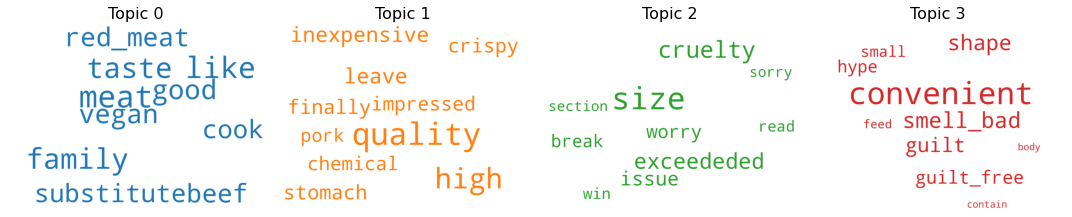

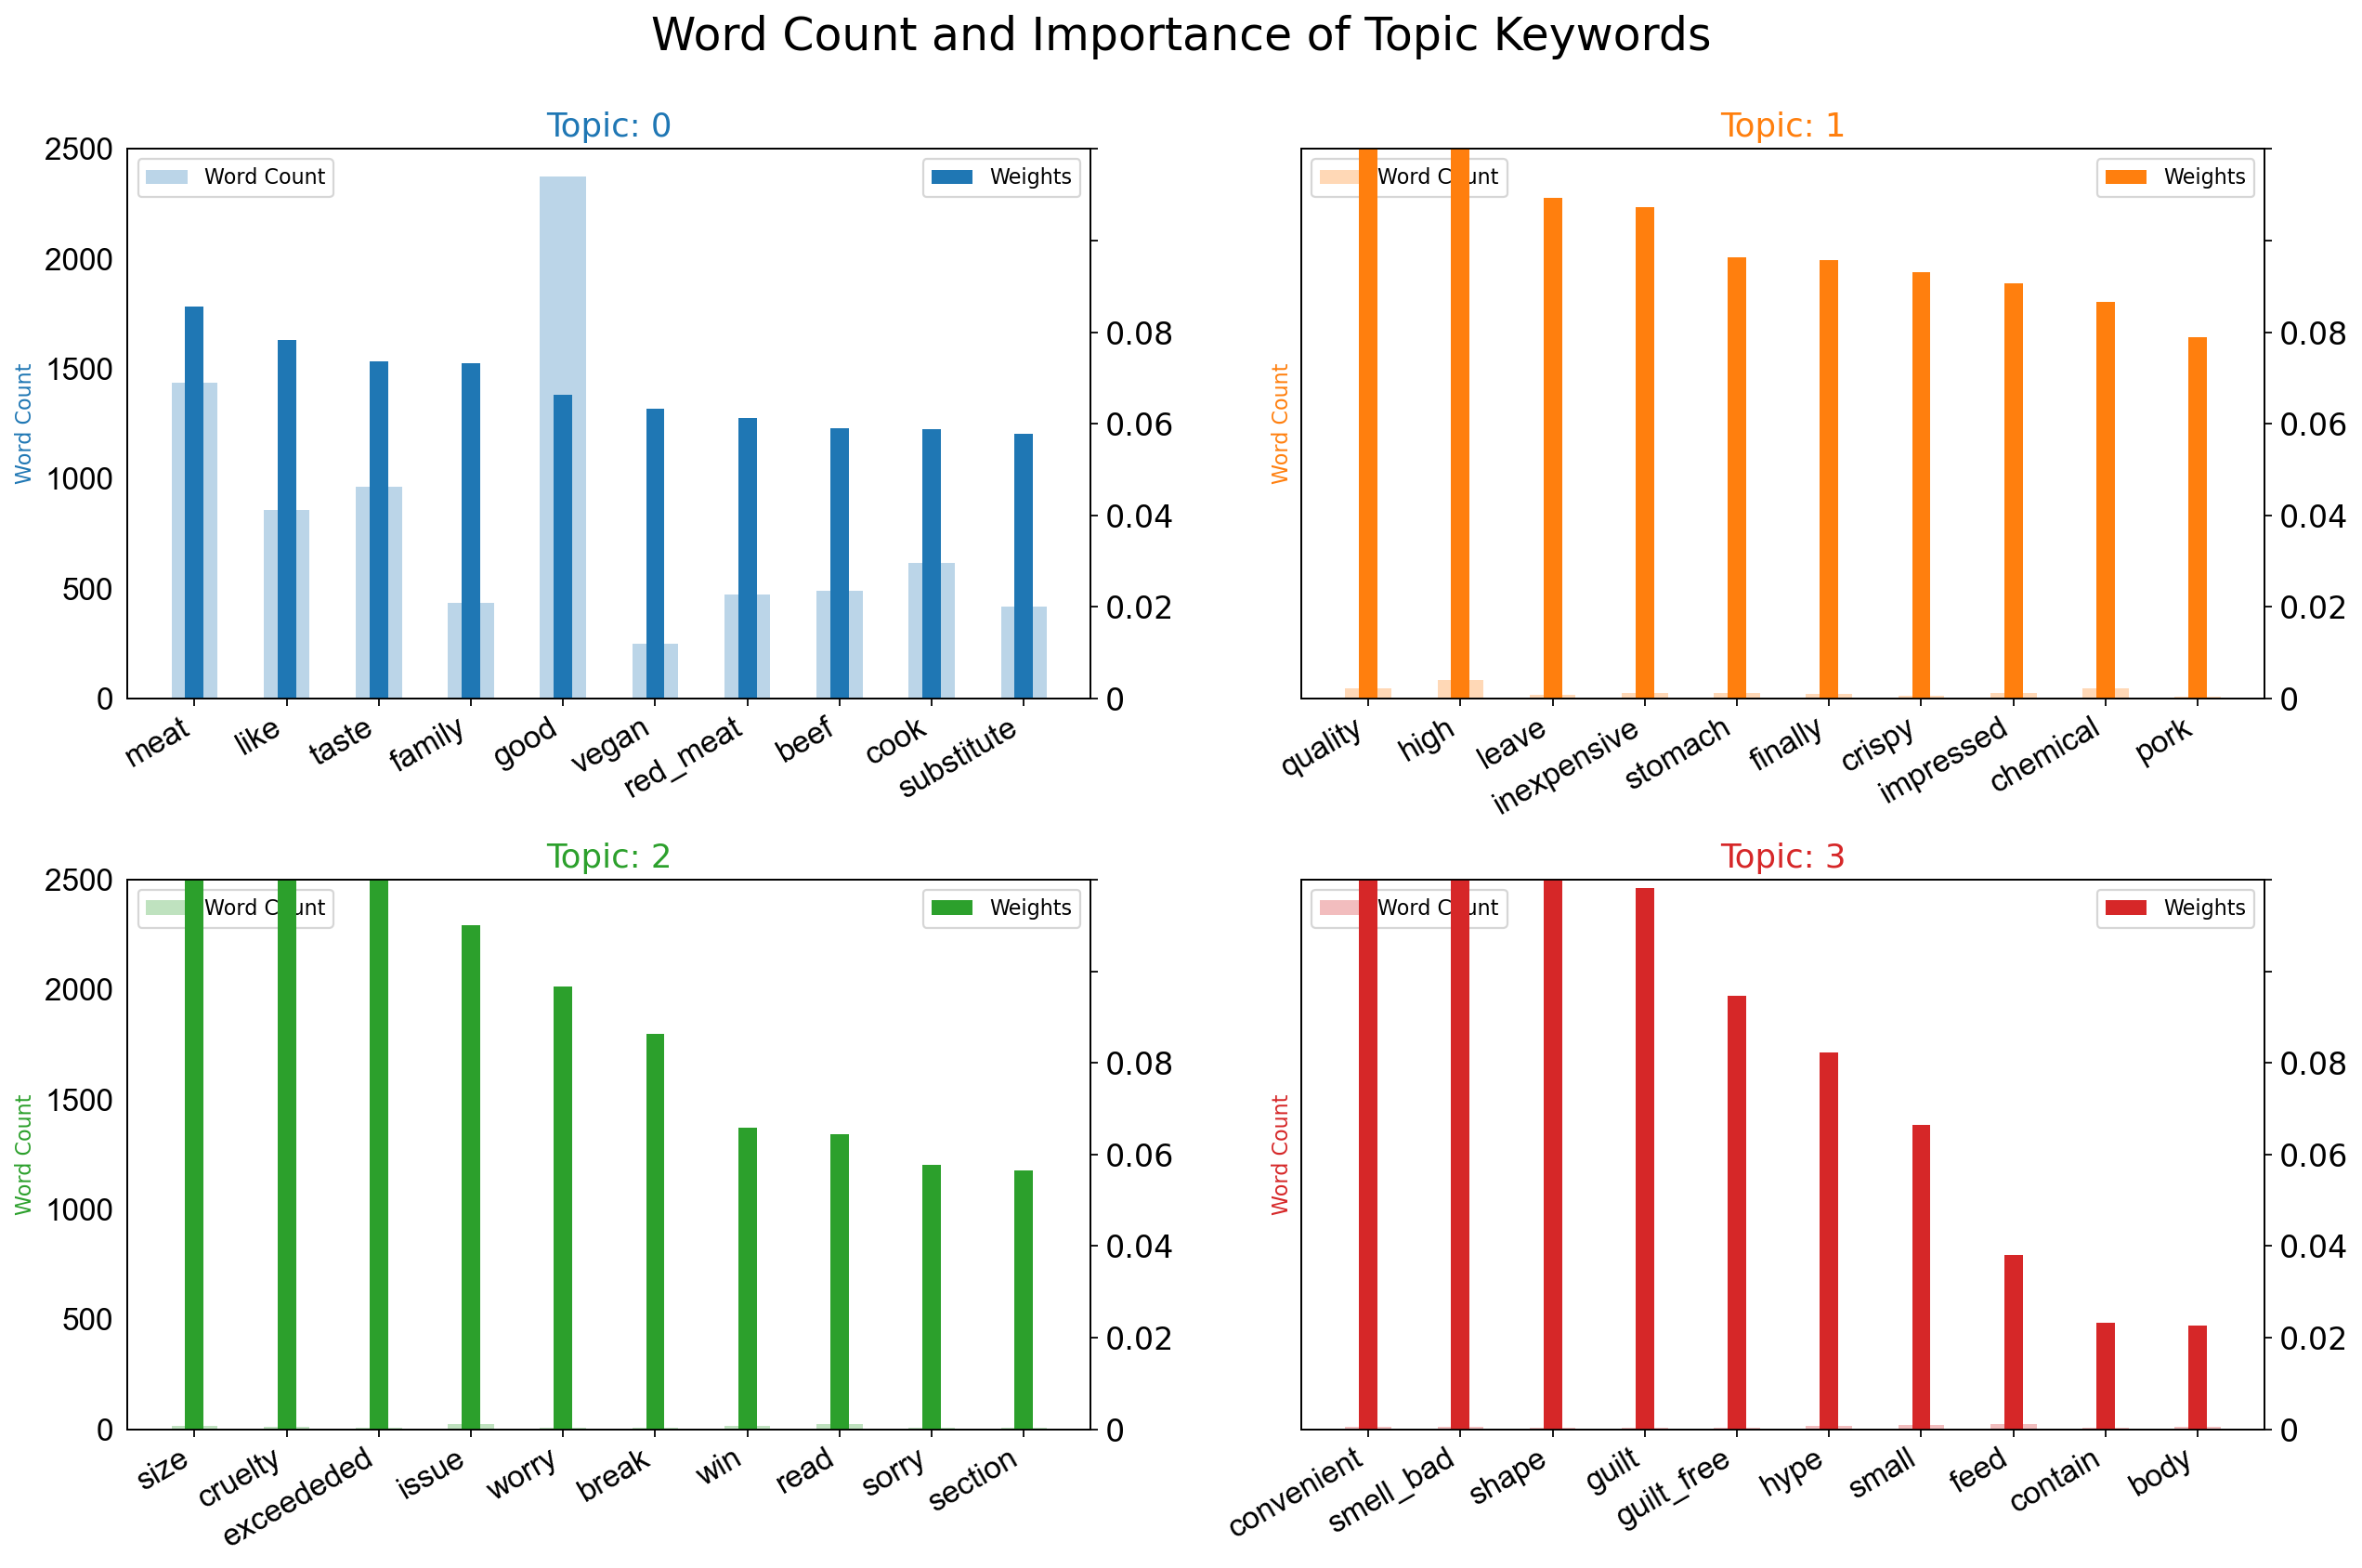

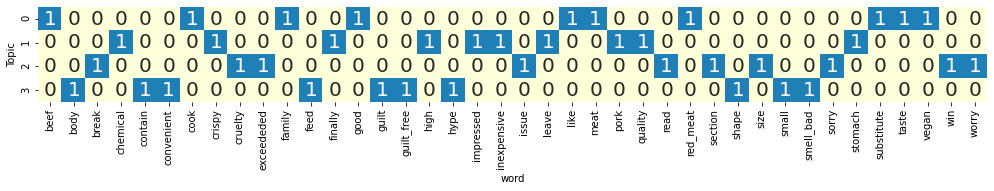

In [38]:
df_topic_sents_keywords = format_topics_sentences(optimal_model_P, doc_term_matrix_P, data_P)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.to_excel("df_TopReviewPerTopic.xlsx")

df_TopReviewPerTopic = getTopReviewsForEachTopic(df_topic_sents_keywords)

df_reviewsInitialText = df_reviews[['Text','TextClean', 'TextClean4']]
df_TopReviewPerTopic.merge(df_reviewsInitialText, how='left', on='Text')
df_TopReviewPerTopic.head()

df_TopReviewPerTopic.to_excel("df_TopReviewPerTopic_P.xlsx")

createwordcloud(optimal_model_P, numberOfTopics_P)
df_wordImp = showTopwordsPertopicInGraph(optimal_model_P)
createheatmapofTopwords(gettopicwordsIntoDataframe(optimal_model_P))

## Observations Reviews  <a class="anchor" id="VisualsPositiveobservations"></a>

From The Above and reviewing the reviews most associated with generating each topic I have developed the following summaries:
1. New Family Favorite!
Great Taste,
Great Texture,
Convenient,
Substitute For Real Meat

2. Worth The Sacrifice
Right Eating Experience & Textures Priced Right,
Some Concerns: Ingredient

3. Worry Free – Win Win Win
Filling - Right Sized,
Eco Friendly,
Animal Friendly

4. Guilt Free Convenience
Easy/ Convenient,
No Compromise of Health,
Some Concerns: Smell

In [39]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()
df_append_P = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    
    df_topic_epitome_reviews = pd.concat([grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0, ignore_index=True)    
    df_append_P = df_append_P.append(df_topic_epitome_reviews, ignore_index=True)

# Reset Index    
df_append_P.reset_index(drop=True, inplace=True)

# Format
df_append_P.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
#df_append_P

In [40]:
# get dataframe of key topics and probs
df_Topic_KeyWords = pd.DataFrame()

for i in range(len(optimal_model.show_topics(formatted=False))):
    topic = optimal_model.show_topics(formatted=False)[i][0]
#     print(topic)
    setofKeyWordsAndValues = optimal_model.show_topics(formatted=False)[i][1]
    df = pd.DataFrame(setofKeyWordsAndValues, columns = ["word", "prob"])
    df['topic'] = i
    df_Topic_KeyWords = df_Topic_KeyWords.append(df, ignore_index = True)

## Negative Reviews <a class="anchor" id="VisualsNegative"></a>

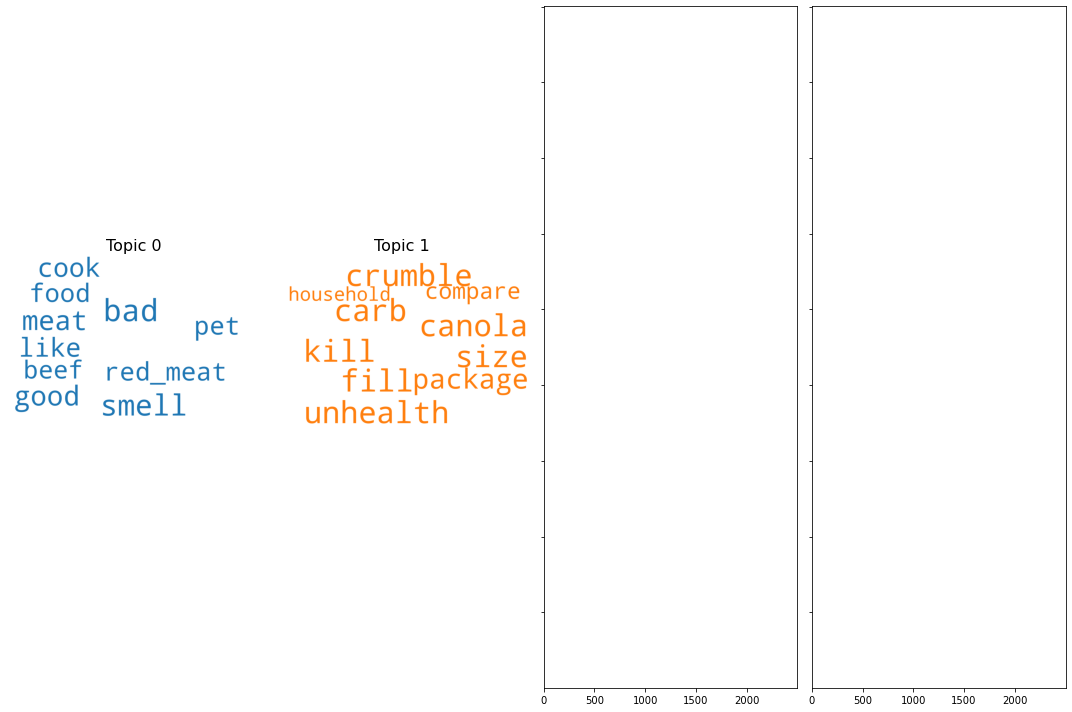

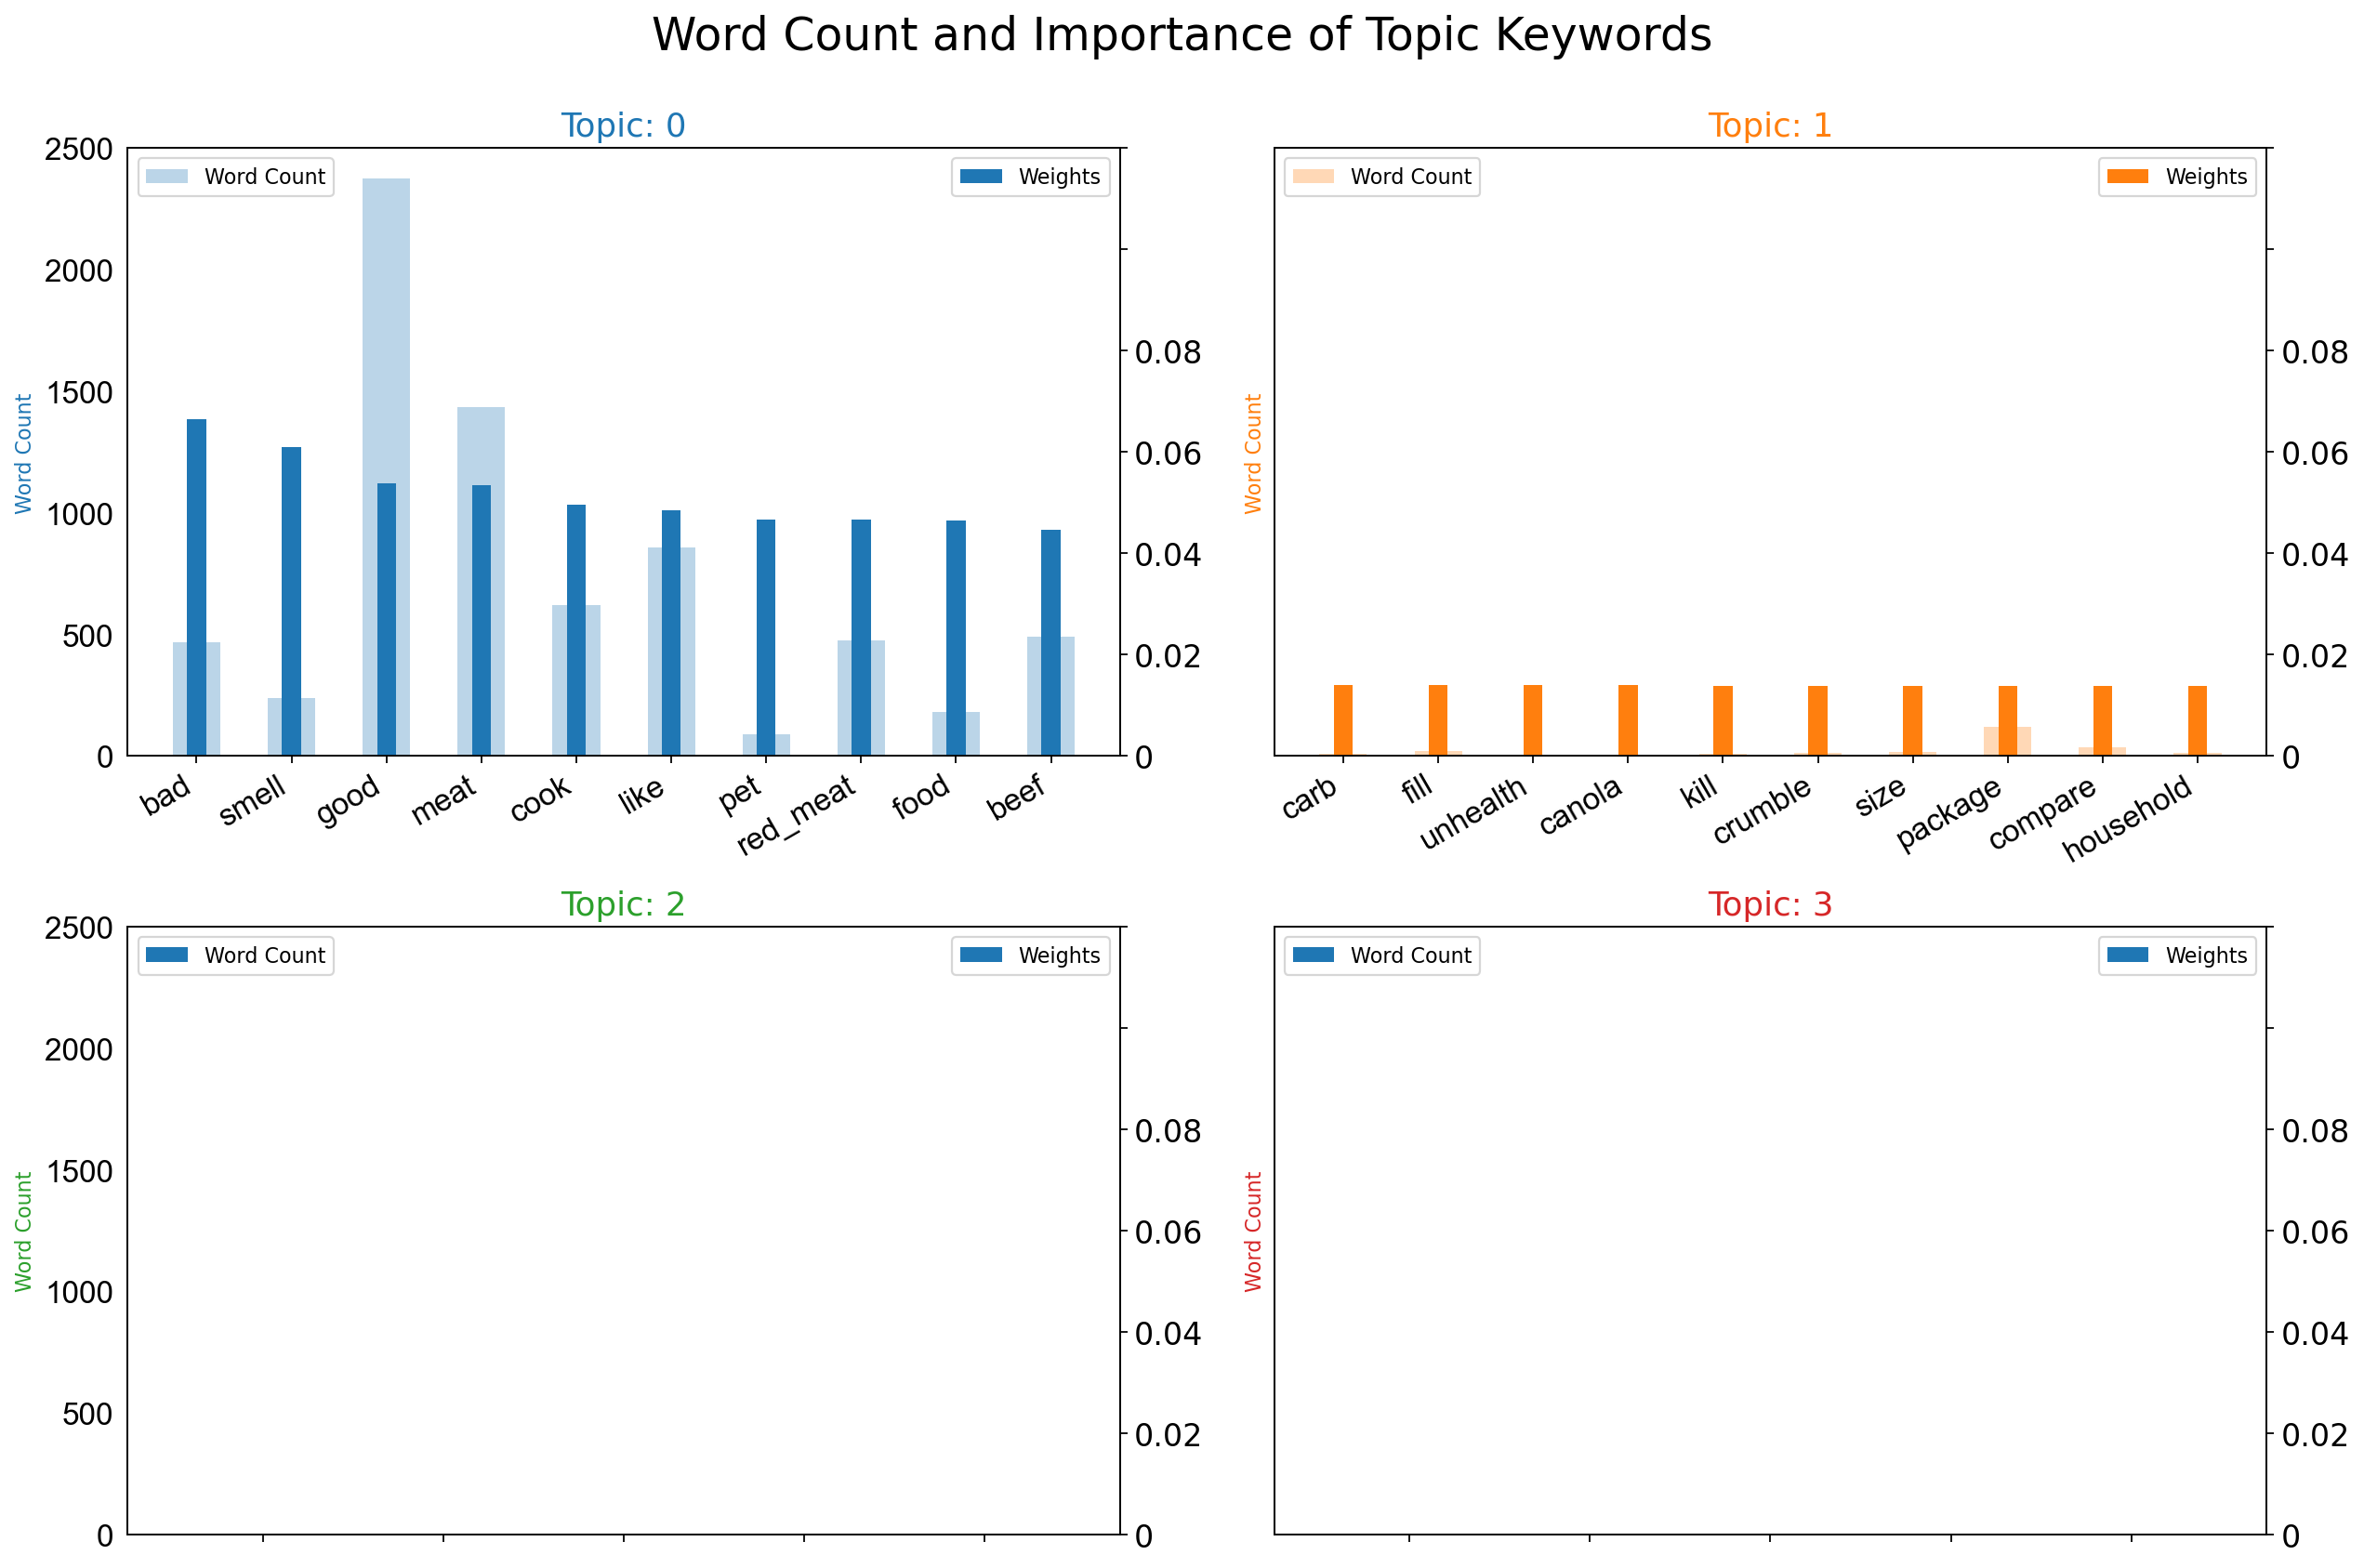

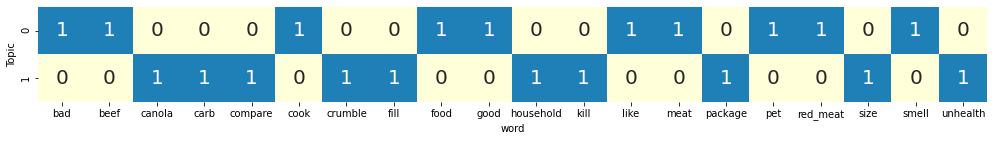

In [41]:
df_topic_sents_keywords = format_topics_sentences(optimal_model_N, doc_term_matrix_N, data_N)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.to_excel("df_TopReviewPerTopic.xlsx")

df_TopReviewPerTopic = getTopReviewsForEachTopic(df_topic_sents_keywords)

df_reviewsInitialText = df_reviews_N[['Text','TextClean', 'TextClean4']]
df_TopReviewPerTopic.merge(df_reviewsInitialText, how='left', on='Text')
df_TopReviewPerTopic.head()

df_TopReviewPerTopic.to_excel("df_TopReviewPerTopic_N.xlsx")

createwordcloud(optimal_model_N, numberOfTopics_N)
df_wordImp = showTopwordsPertopicInGraph(optimal_model_N)
createheatmapofTopwords(gettopicwordsIntoDataframe(optimal_model_N))

In [42]:
df_topic_sents_keywords.Dominant_Topic.value_counts()

0.0    134
Name: Dominant_Topic, dtype: int64

In [43]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()
df_append_N = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    print(f'i = {i}')
#     print(grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5))
    
    
    df_topic_epitome_reviews = pd.concat([grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0, ignore_index=True)
    
#     testAppend =  grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)
    
    df_append_N = df_append_N.append(df_topic_epitome_reviews, ignore_index=True)
 
    #test = df_topic_sents_keywords1.groupby(['Dominant_Topic'], as_index=False)[0].count()
    
#     print(type(df_topic_epitome_reviews))
#     sent_topics_sorted

# Reset Index    
df_append_N.reset_index(drop=True, inplace=True)

# Format
df_append_N.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
#df_append_N

i = 0.0


## Observations Reviews  <a class="anchor" id="VisualsNegativeobservations"></a>

From The Above and reviewing the reviews most associated with generating each topic I have developed the following summaries:
1. Buyer Beware!
Terrible Smelling,
Resembles Wet Pet Food,
Not A Substitute For Real Meat

2. Not Worth The Sacrifice
Chemical experiment,
Cost 2x real thing

# Conclusions <a class="anchor" id="Conclusions"></a>

Based on the above I have landed on 6 topics bewteen the two dataset.  In the future more data would be helpful in creating more robust topics.  I have the following for suggestions:

* [Retailers Should Motivate More On-line Consumer Reviews] - Quantity & Diversity of Thought: One of the challenges of this project was amassing enough data to obtain the quantity of data required to create robust models. In order to encourage this type of analysis in the future and across several categories more reviews would be helpful, also pushing consumer to generate organic thoughts for targeted product attributes, dislikes, etc.

* [Developing More Expendables Models] - More Sources of Data: Per the above obtaining data is a challenge. Additionally, obtaining data that is also rated is even more of a challenge. In order to combat this problem I could develop an algorithm that would take the ratings from reviews that allow the user to enter a ratings (amazon) and using that data to project a rating on to reviews from social media sites that do not allow the user to enter a rating (Twitter,TikTok, FB). By creating a more extendable model will allow for the use of more sources of data, and ultimately increases the quantity. This is especially true for procuring negative slanted comments, this was particularly evident in this project.

* [Leveraging Video Content to Create Reviews] - While scraping data for this project, sites such as twitter, resulted in leaving many great reviews out of the analysis. I encountered several tweets that contained the words "Beyond Burger Review" or "Impossible Burger Review" that were not really usable reviews but instead were really just links to youtube/ other videos containing the actual reviews. If there was a technology to summarize videos down to a review would be invaluable.